In [2]:
from fastai2.text.all import *
import plotly.express as px

In [3]:
df = pd.read_csv('tweets_100thou.csv')

In [40]:
df.head()

,target,id,date,flag,user,text,is_valid
0,0,2233254056,Thu Jun 18 21:04:20 PDT 2009,NO_QUERY,celestislove,uon't go to school today. Sorry sports jrn,False
1,4,2184967497,Mon Jun 15 16:41:10 PDT 2009,NO_QUERY,yeahshestamps,Making pasta and insalata blu with mom,True
2,0,1691306190,Sun May 03 17:33:58 PDT 2009,NO_QUERY,Dubtron9000,Worst. Day. Ever. Needing some legitimate hug action. Show starts in 30,True
3,4,1827681634,Sun May 17 11:13:28 PDT 2009,NO_QUERY,Travel_Trips,@riqfreire Aproveiteeeeeeeeeeeeeeeee!!,False
4,4,1972614114,Sat May 30 09:33:25 PDT 2009,NO_QUERY,Richpinoc,Sitting in the Tower District (gay district) in Fresno,False


## Trial 1

In [4]:
dls = TextDataLoaders.from_df(df, valid_col="is_valid", text_col='text', label_col='target')

In [43]:
dls.show_batch()

,text,category
0,"xxbos xxmaj the xxmaj sun xxmaj is xxmaj out , xxmaj it 's xxmaj hot & & xxmaj there xxmaj is n't a xxmaj cloud xxmaj in xxmaj the sky .. what xxmaj shall xxmaj we xxmaj do ? xxmaj time xxmaj to xxmaj get xxmaj the xxmaj grill xxmaj going xxmaj grab a xxmaj beer & & xxmaj get xxmaj in xxmaj that xxmaj pool",4
1,xxbos xxmaj good xxmaj morning xxmaj everyone . xxmaj looks xxmaj like xxmaj today 's xxmaj gon na xxmaj be a xxmaj beautiful xxmaj one . xxmaj gon na xxmaj try xxmaj and xxmaj get xxmaj out xxmaj and xxmaj get xxmaj some xxmaj vitamin xxup d. xxmaj happy xxmaj hump xxmaj day xxmaj ya'll xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4
2,xxbos xxup this xxup town xxup will xxup be xxup the xxup downfall xxup of xxup us xxup all ! ! xxmaj makes me sad i missed such epic - ness … xxmaj also : & ' xxunk xxup moines ! ! & ' xxmaj xxunk … rock on boys … rock on xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0
3,xxbos xxmaj whoo h xxrep 4 o ! xxup feel xxup good xxup music here ! http : / / bit.ly / xxunk xxup enjoy ! ! xxup just xxup added a xxup really xxup funny xxup video ! xxmaj throw xxmaj yo xxmaj hands xxmaj up ! ( please retweet ) xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4
4,xxbos xxmaj listening to : 50 xxmaj cent - i xxmaj get xxmaj money … i xxup forgot xxup how xxup much xxup this xxup song xxup hits xxrep 3 ! xxup wow xxrep 3 ! xxmaj flow on this song = & ' get xxmaj rich or xxmaj die xxmaj xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4
5,xxbos its just a book still pissed cuz i ai nt got xxmaj deja xxmaj king : & ' queen xxmaj bitch & ' or & ' last xxmaj bitch xxmaj standing & ' but i m a get it soon ( i hope ) lol xxunk ® â¥ xxunk nite xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4
6,"xxbos xxmaj at the end of the day , can we say , & ' i did what had 2 b done . i did my best . i lived in my heart 2 day . & ' xxmaj if so … it was a xxup good day xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",4
7,xxbos please talk to m xxrep 5 e … . xxup i 'm xxup so xxup bore xxrep 4 d xxunk today is xxup monday ! i just want to stay at home and surf da net in my own comp .. how xxrep 3 a xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0
8,"xxbos xxmaj who xxmaj likes xxmaj the xxmaj show xxmaj ghost xxmaj xxunk ) ? xxmaj do xxmaj you xxmaj believe xxmaj the xxmaj stuff … : xxunk said , . xxmaj june 5 , 2009 @ xxunk .. http : / / bit.ly / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",4


In [44]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=7.585775847473997e-07)

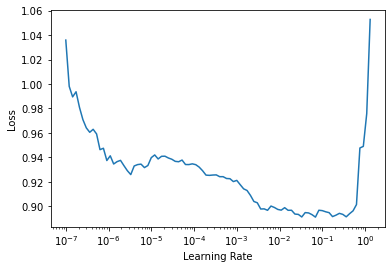

In [45]:
learn.lr_find()

In [46]:
learn.fine_tune(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.773181,0.574068,0.698450,00:44


epoch,train_loss,valid_loss,accuracy,time
0,0.586839,0.516505,0.739600,01:28
1,0.524948,0.484331,0.762900,01:30
2,0.509391,0.469365,0.772250,01:29
3,0.487433,0.464466,0.777500,01:29


In [48]:
learn.show_results()

,text,category,category_
0,xxbos xxmaj it 's xxmaj been a xxmaj while … xxmaj but i xxmaj been xxmaj busy ! ! xxmaj xxunk xxmaj tha xxmaj show … xxmaj now xxmaj i 'm xxmaj celebrating ! ! xxmaj i 'm xxmaj ur 2009 xxmaj mr . xxmaj muscle xxmaj beach xxrep 3 ! i xxmaj took xxmaj tha xxmaj show xxmaj baby xxrep 3 !,4,4
1,xxbos # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day xxpad xxpad,4,4
2,xxbos xxup is xxup asking xxup all xxup of xxup twitter … . xxup how xxup do xxup you xxup get xxup great xxup amount xxup of xxup twitter xxup traffic xxup to xxup be xxup sent xxup to xxup your xxup website xxrep 4 ? xxup that s xxup all i xxup ask ? xxup please xxup help ! ! xxpad xxpad,0,4
3,xxbos xxup just xxup got xxup back xxup from xxup cedar xxup point xxup in xxup oh . xxup lil xxup road xxup trip xxup for xxup da xxup fam xxup rode xxup every xxup thing xxup uno xxup g 's xxup ai nt xxup scared xxup of xxup no xxup roller xxup coaster xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0
4,xxbos xxunk i xxup do n't xxup want xxup him xxup to xxup go xxup xxunk xxrep 3 r . xxrep 3 ( xxmaj it 's so xxunk xxrep 3 g … xxmaj he 's booked & & everythin xxrep 3 g . i think he 's leaving xxmaj september 3 . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,0
5,"xxbos @tommcfly xxup you 're xxup so xxup bad xxup man ! xxup god , xxup please xxup you xxup can xxup say xxup anything xxup with xxup me xxup or xxup reply xxup my xxup other xxup message ! xxup please , i xxup love xxup you ! xxup xx xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",4,4
6,xxbos ca n't get this & ' must xxup be xxup love & ' song by xxmaj cassie outta my head . xxmaj it 's still on repeat & & it 's helping me get through the dayy . xxmaj i 'm s xxrep 3 o sleepy xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,0
7,xxbos xxunk xxup wrong .. wrong … right ! xxmaj stupid xxmaj bitch ! xxmaj he xxmaj is xxup not xxmaj fat ! xxmaj all i xxmaj do xxmaj is xxmaj twitter xxmaj all xxmaj my friends .. i xxmaj dnt xxmaj call xxmaj ppl xxmaj anymore xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0
8,"xxbos xxup bbq was g xxrep 5 r xxrep 5 e att yesterday ! ! xxmaj ate 2 xxunk , 2 dogs , and two corn on xxunk ! ! xxup yes ! ! i xxup am a xxup monster ! ! xxup ga xxrep 4 r xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",4,4


In [49]:
learn.predict("Rest in power, Chadwick. This is all still too difficult to process, thank you for all the movies and all the inspiration. We love you so much")

('4', tensor(1), tensor([0.0423, 0.9577]))

In [50]:
learn.predict("Rest in power, chadwick. This is all still too difficult to process")

('0', tensor(0), tensor([0.9313, 0.0687]))

## Fine tuning

In [6]:
dls_lm = TextDataLoaders.from_df(df, is_lm=True, text_col='text', valid_pct=0.2, bs=128)

In [52]:
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj chick xxmaj fil a later … . xxbos @gulpanag xxmaj mornin ' lady ! xxmaj have a great day ahead , shooting star xxbos xxmaj xxunk from my neighbors bday party . i was fu xxrep 3 n there was a bouncy and water balloon fight ! xxmaj but i forgot sunblock and now i ca n't move xxbos xxunk lol yea ! i keep thinking about what we 're","xxmaj chick xxmaj fil a later … . xxbos @gulpanag xxmaj mornin ' lady ! xxmaj have a great day ahead , shooting star xxbos xxmaj xxunk from my neighbors bday party . i was fu xxrep 3 n there was a bouncy and water balloon fight ! xxmaj but i forgot sunblock and now i ca n't move xxbos xxunk lol yea ! i keep thinking about what we 're doing"
1,"nights ! xxbos xxmaj i 'm at page 80 / 400 pages of my text . xxmaj how much am i supposed to memorize ? ! xxmaj my brain ca n't take it ! xxmaj i 'm not a xxunk ! xxbos has no fone and is lonely xxbos xxunk i m starting too , i ca nt upload a photo though xxup hey does xxunk have twitter ? keen to stalk","! xxbos xxmaj i 'm at page 80 / 400 pages of my text . xxmaj how much am i supposed to memorize ? ! xxmaj my brain ca n't take it ! xxmaj i 'm not a xxunk ! xxbos has no fone and is lonely xxbos xxunk i m starting too , i ca nt upload a photo though xxup hey does xxunk have twitter ? keen to stalk …"
2,"was in the xxmaj house xxmaj but i like him bcause he 's running completly on ideas , and being xxup lg is about ideas xxbos xxunk xxunk sleep well charles you make xxunk a lot ! xxbos xxmaj fome , fome , fome ! ! xxbos xxmaj everthing hurts . xxbos xxunk i agree ! xxmaj i 'm having to deny about 10 ' experts ' per day ! xxmaj it","in the xxmaj house xxmaj but i like him bcause he 's running completly on ideas , and being xxup lg is about ideas xxbos xxunk xxunk sleep well charles you make xxunk a lot ! xxbos xxmaj fome , fome , fome ! ! xxbos xxmaj everthing hurts . xxbos xxunk i agree ! xxmaj i 'm having to deny about 10 ' experts ' per day ! xxmaj it 's"


In [53]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1, )

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.033113110810518265)

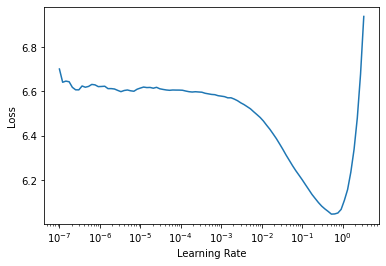

In [54]:
learn.lr_find()

In [55]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.775272,4.402635,0.228717,81.665787,02:28


In [56]:
learn.save('1epoch_fit_one_cycle')

In [57]:
learn = learn.load('1epoch_fit_one_cycle')

In [58]:
learn.unfreeze()
learn.fit_one_cycle(6, 5e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.428035,4.251678,0.246946,70.223183,02:44
1,4.304978,4.165888,0.257260,64.449905,02:44
2,4.204672,4.115406,0.262313,61.277088,02:44
3,4.100685,4.086133,0.267449,59.509323,02:44
4,4.012729,4.076208,0.269033,58.921623,02:44
5,3.963781,4.079766,0.268960,59.131649,02:44


In [59]:
learn.save_encoder('finetuned')

In [60]:
TEXT = "WALKING HOME"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [61]:
print("\n".join(preds))

WALKING HOME ! my luggage have been at Columbus Field for a month . Wish i could do a transfer to my computer . Just realised why May i have to be an AT&&T store
WALKING HOME FROM THE PARK WITH THE BF Is in the hospital , so not sure if she 's going to be home Its raining outside and i wish i was in


## Train the text classifier

In [7]:
dls_clas = TextDataLoaders.from_df(df, valid_col="is_valid", text_col='text', label_col='target', text_vocab=dls_lm.vocab)

In [8]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [9]:
learn = learn.load_encoder('finetuned')

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.001737800776027143)

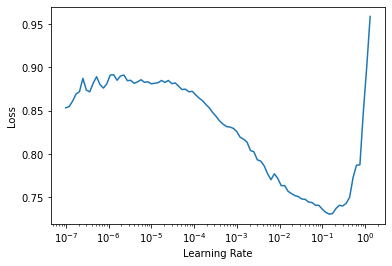

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.589490,0.457047,0.780350,00:49


In [12]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.468958,0.421705,0.801100,00:55


In [13]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.445963,0.419821,0.800650,01:05


In [14]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4)/5,1e-3/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.443092,0.413514,0.807050,01:24
1,0.426087,0.410975,0.807150,01:23


In [15]:
learn.fit_one_cycle(2, slice(1e-3/(2.6**4)/5,1e-3/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.427607,0.408234,0.809400,01:22
1,0.411414,0.407558,0.809600,01:23


In [16]:
learn.show_results()

,text,category,category_
0,xxbos xxmaj it 's xxmaj been a xxmaj while … xxmaj but i xxmaj been xxmaj busy ! ! xxmaj xxunk xxmaj tha xxmaj show … xxmaj now xxmaj i 'm xxmaj celebrating ! ! xxmaj i 'm xxmaj ur 2009 xxmaj mr . xxmaj muscle xxmaj beach xxrep 3 ! i xxmaj took xxmaj tha xxmaj show xxmaj baby xxrep 3 !,4,4
1,xxbos xxunk i xxup do n't xxup want xxup him xxup to xxup go xxup xxunk xxrep 3 r . xxrep 3 ( xxmaj it 's so xxunk xxrep 3 g … xxmaj he 's booked & & everythin xxrep 3 g . i think he 's leaving xxmaj september 3 . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,0
2,xxbos xxmaj talking xxmaj to xxmaj alyssa and xxmaj chillin out .. going xxmaj through xxmaj pictures xxmaj my xxmaj xxunk ( ( xxunk ) ) xxmaj sent xxmaj mee xxmaj oh xxup yea ! xxmaj lol xxmaj but xxmaj anyway … i xxmaj miss xxmaj my xxmaj xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,0
3,xxbos xxmaj i 'm goin to xxup l.a . tomorrow night … .have to leave my puppies i do n't how xxmaj i 'm going to deal . xxup but xxup i 'm xxup going xxup to xxup the xxup beach xxrep 3 ! i will deal ! xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,0
4,"xxbos xxmaj i 'm back xxrep 3 ! xxmaj i 'm # alive & & # kicking ! xxmaj no xxunk , no xxunk ! xxmaj xxunk * in one piece * xxup jb was … overrated . xxmaj but had a great time with my ladies ! xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",4,4
5,"xxbos xxmaj i 'm tired of the sun . xxmaj it 's not going away for days yet , but xxmaj i 'm done with it . xxmaj where can i go to escape ? xxmaj sad , it 's only in the mid 70 's xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",0,0
6,"xxbos xxmaj there was never any reason for me to be hopeful . xxmaj i 'll just let the tide take me . xxmaj one day xxmaj i 'll get & ' her . & ' xxmaj when i do , this will be silly … xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",0,0
7,xxbos xxmaj lemme find out xxunk is on xxmaj miss xxmaj twitter xxrep 3 ! xxmaj lol … xxrep 3 a xxup nd i wanted to bowl last nite so bad n u ai n't txt bak ! xxup i 'm xxup over xxup it ! xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,0
8,"xxbos xxmaj family 's gone … .. i 'm all alone … … w xxrep 3 o h xxrep 3 o xxrep 5 ! xxup lol xxmaj unfortunately , i have lots of cleaning to do xxmaj time to pop in xxup xxunk and start … xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",0,0


In [17]:
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.420367,0.404707,0.811150,01:23


In [18]:
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.409222,0.403688,0.811150,01:23


In [19]:
preds = learn.get_preds()

In [20]:
preds[0][:4]

tensor([[0.0173, 0.9827],
        [0.7907, 0.2093],
        [0.8137, 0.1863],
        [0.8775, 0.1225]])

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

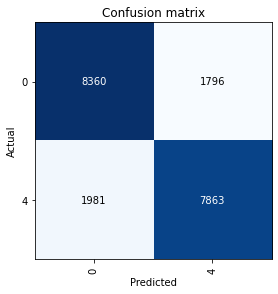

In [22]:
interp.plot_confusion_matrix()

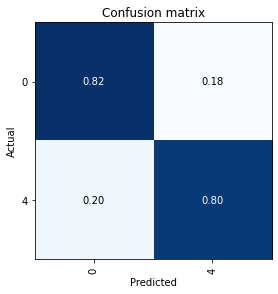

In [23]:
interp.plot_confusion_matrix(normalize='true')

In [81]:
interp.top_losses()

torch.return_types.topk(
values=tensor([6.6708e+00, 6.3969e+00, 6.2744e+00,  ..., 2.2531e-04, 1.8549e-04,
        1.2493e-04]),
indices=tensor([ 7857,  2312, 17645,  ..., 11439, 19749, 17233]))